


# DenseNet121 ve Çoklu Optimizer Yaklaşımı
<br>

### İçerikler
* Kütüphaneler
* Veriyi Yükleme ve Normalize Etme
* Preprocessing Layerları
* Transfer Learning Nedir?
  * 1) Önceden Eğitilmiş Modeli Doğrudan Kullanmak
  * 2) Önceden Eğitilmiş Modelleri Özellik Çıkarıcı (Feature Extractor) Olarak Kullanmak
  * 3) Önceden Eğitilmiş Modelin Son Katmanlarını -Fine Tune- Etmek
  * 4) Başlangıç Noktası Olarak Önceden Eğitilmiş Bir Model Kullanmak
* Optimizerlar
  * RAdam
  * Lookahead
  * LazyAdam
* Multi-Optimizer Wrapper - TensorFlow Addons
* Modelin Test Setindeki Başarısı

## Kütüphaneler

In [1]:
!nvidia-smi

Sat Dec 25 20:46:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

from matplotlib import pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("Tensorflow version " + tf.__version__)

1 Physical GPUs, 1 Logical GPUs
Tensorflow version 2.6.2


2021-12-25 20:46:14.554014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 20:46:14.646454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 20:46:14.647128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-25 20:46:14.649866: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Veriyi Yükleme ve Normalize Etme
* [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), 32x32 RGB resimler ve 10 tane sınıf bulunduran bir görsel verisetidir.
<br>

* TensorFlow Datasets (TFDS) kullanarak verisetini yükleyeceğiz. TFDS içinde hazır verisetleri bulunduran bir modüldür.

In [3]:
def normalize_and_onehot(features, labels):
    return tf.cast(features, tf.float32) / 255.0, tf.one_hot(labels,10)

* `split` ile mevcut olan setleri seçip isteğimize göre bölebiliriz. Bu veriseti için **train** ve **test** spliti mevcuttur ve burada **train** split'inin %90'ını asıl eğitim ve geri kalanını ise **validation dataset** olarak kullanacağız.
<br>

* `as_supervised = True`, dataset yüklenirken içeriklerinin `(data, label)` olacak şekilde (tuple olarak) yükler.

<br>

* `shuffle`, `prefetch` gibi fonksiyonları [diğer notebook'umda](https://github.com/Frightera/TensorFlow-2.X-Ogretici-Notebooklar-Turkce/blob/main/X%20-%20tf.data%2C%20tf.image%2C%20tfa.image%2C%20MiniDenseNet%2C%20RAdam%20Part%201-2.ipynb) açıkladığım için burada detaylarına girmiyorum.

In [4]:
train_ds, val_ds, test_ds = tfds.load('cifar10', split=['train[:90%]', 'train[90%:]', 'test'],
                             as_supervised=True)

train_ds = train_ds.batch(64).map(normalize_and_onehot).shuffle(1024).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).map(normalize_and_onehot).shuffle(1024).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(64).map(normalize_and_onehot).shuffle(1024).prefetch(tf.data.AUTOTUNE)

2021-12-25 20:46:16.927242: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
train_ds

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 10)), types: (tf.float32, tf.float32)>

## Modeli Tanımlayalım

* Eğitim sırasında modelin eğitimdeki resimlerin farklı hallerini görmesi için `Preprocessing layer` kullanacağız. İsimlerinden de anlaşılacağı üzere rastgele dönüşümler uygulayacaklar, verilen değerler (0.1) ile oynanabilir. Dikkat edilmesi gereken şey ise resimleri aşırı bozmamak.

<br>

* Burada kullanacağımız `RandomZoom`, `RandomRotation` ve `RandomContrast` layerları modelin predict aldığı aşamada devre dışıdır.

<br>

* Daha sonra bu dönüşümleri görmek için görselleştireceğiz.

In [6]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomZoom(0.1, 0.2),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomContrast(0.2)])

2021-12-25 20:47:20.907204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


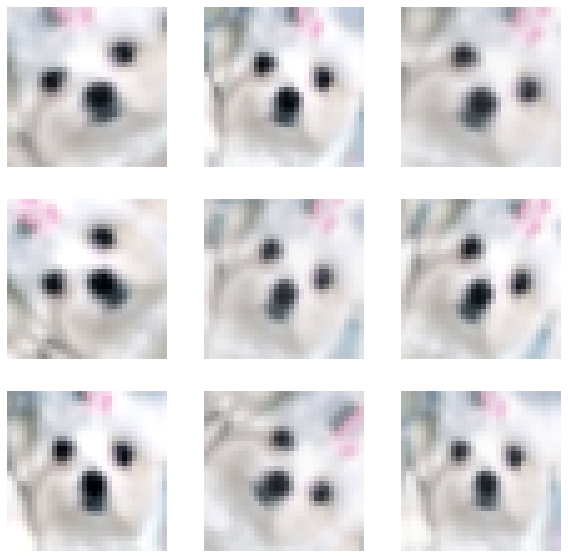

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images) # Model olduğu için call yapabiliriz.
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy())
        plt.axis("off")

## Transfer Learning Nedir?
Transfer Learning, yeni ve benzer görevler için önceden eğitilmiş mevcut modelleri yeniden kullanmaya yönelik bir derin öğrenme tekniğidir. Bildiğimiz gibi, derin öğrenme modelleri veriye açtır (data hungry). Ayrıca, büyük verisetleri ile devasa modelleri eğitmek, hesaplama yapmak açısından pahalıdır. Bu nedenle, iki temel sorun vardır:

* Veri eksikliği

* Hesaplama kaynaklarının eksikliği (GPU, TPU)

**Transfer Learning bu sorunları çözmeyi amaçlar. Transfer Learning yaklaşımında bazı stratejiler vardır:**

<br>

#### 1) Önceden Eğitilmiş Modeli Doğrudan Kullanmak

Bu stratejide, önceden eğitilmiş model, ancak ve ancak hedef verilerde de aynı sınıflar varsa, daha fazla eğitim süreci olmadan hedef sorunu çözebilir.

* **Örnek**: State-of-the-art object detection modelleri büyük ölçekli verisetleri üzerinde eğitildiğinden doğrudan hedef probleme uygulanabilir. Bu verisetleri yüzlerce benzersiz sınıf içerdiğinden modeller yeni task için hedef sınıfları tahmin edebilecektir.

<br>

#### 2) Önceden Eğitilmiş Modelleri Özellik Çıkarıcı (Feature Extractor) Olarak Kullanmak
Önceki örnekte olduğu gibi önceden eğitilmiş modeli doğrudan kullanmak yerine, tamamen bağlı katmanları (fully connected layer) atarak bu modeli bir özellik çıkarıcı olarak ele alabiliriz. Bu, çoğunlukla CNN'lerde kullanılan bir stratejidir. **Convolution**'lar sadece kayan filtreler olduğundan, görüntü boyutuyla ilgilenmediğinden (görüntü kanalları eşleşmelidir) özellik çıkarıcı gibi davranabilirler. Bu strateji, veriseti oldukça küçük olduğunda yaygın olarak kullanılır.

* **Örnek 1**: ImageNet verisetinde eğitilmiş önceden eğitilmiş bir model alabilir ve convolutionların sonucunu dense layerlara aktarabiliriz. Bu, hedef görüntü/veriseti için özellikleri korurken önceden eğitilmiş ağa çıktı katmanları eklememize izin verir.

* **Örnek 2**: Bir embedding sıfırdan eğitmek bazen zor olabilie. **GloVe** gibi önceden eğitilmiş embeddingler, bir özellik çıkarıcı işlevi görebilir.

#### 3) Önceden Eğitilmiş Modelin Son Katmanlarını -Fine Tune- Etmek
Ayrıca mevcut modelin katmanlarında -ince ayar- yapabiliriz. Bu stratejide, önceden eğitilmiş modelin bazı katmanları dondurulur ve eğitim sırasında güncellenmez. Yani backpropagation sürecine dahil edilmezler.

* **Örnek 1**: Ana modelin bir araba veriseti üzerinde eğitildiğini varsayalım ve yeni hedef veriseti arabalarla ilgi veya benzerse en son katmanlarda fine tune yapabiliriz. İlk CNN katmanları düşük seviyeli özellikleri öğreneceğinden, çoğu durumda son katmanlara ince ayar yapmak yeterlidir.

#### 4) Başlangıç Noktası Olarak Önceden Eğitilmiş Bir Model Kullanmak

Bahsetmek istediğim son strateji, rastgele ayarlanmış ağırlıklarla başlamak yerine önceden eğitilmiş modelin ağırlıklarını bir başlangıç noktası olarak kullanmaktır. Görevler benzerse ve oldukça büyük miktarda veri varsa, bu model faydalı olabilir. Ancak katmanların hepsi eğitim sürecine dahil edileceğinden, yani eğitim sırasında hepsi yeni veri noktalarıyla güncelleneceğinden bu, hesaplama açısından yoğun olacaktır.

* **Örnek 1**: Önceden eğitilmiş bir ResNet-50 CNN alınabilir ve ağırlıkları bir başlangıç noktası olarak kullanılabilir.

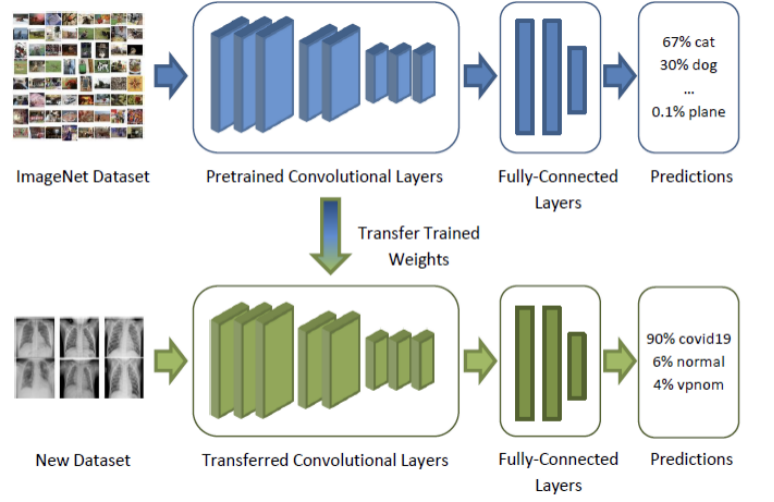
<center>Kaynak: https://dergipark.org.tr/en/pub/dubited/article/878779 </center>

## Rectified-Adam, Lookahead ve Lazy-Adam

<br>

#### Rectified-Adam
* Basit bir ifadeyle RAdam yazarları, uyarlanabilir momentumlu ve LR optimizerların (Adam, RMSProp vb.) bir warm-up phase gerektirdiğini ortaya koydular. Optimizer'ın yeni başladığı bir eğitimde kötü bir lokal minimum'a düşmesinin kolay olduğu durumda optimizasyon sorunu olabileceğini söylediler.

* Sebep olarak ise eğitimin başında optimizerın yeterli veriyi görmeden doğru ve adaptif momentum-LR seçimi yapılamayacağından bahsettiler.

* Çözüm olarak ise bir doğrultucu (rectifier) fonksiyonunun kullanılmasını önerdiler. Bu fonksiyon, karşılaşılan varyasyona dayalı olarak belli "warm-up" değerleri hesaplayabilir. 

**Diğer kelimelerle ifade etmek gerekirse:**
 * Adam vb. gibi optimizerlar'ın yüksek varyansı olduğunu ve ilk batchlerde genelleme konusunda sıkıntı olduğunu,
 * RAdam'ın, düşük bir LR ile ısınma turu yaptığından ve
 * İlk batchlerde momentum terimini kullanmadığından
bahsedebiliriz. 

<br> 

İlgilenenler için **RAdam :)**

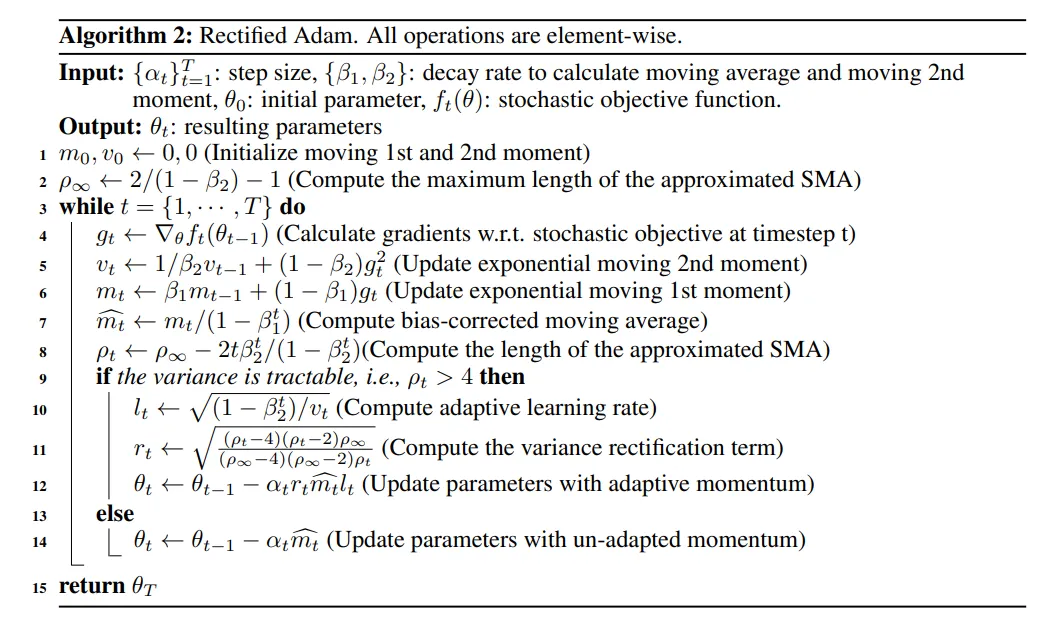


#### Lookahead ~ Ref: https://lessw.medium.com/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d
* Bir dağın tepesinde olduğunuzu düşünün ve aşağı inmek için birden fazla yolunuz olduğunu varsayın. 
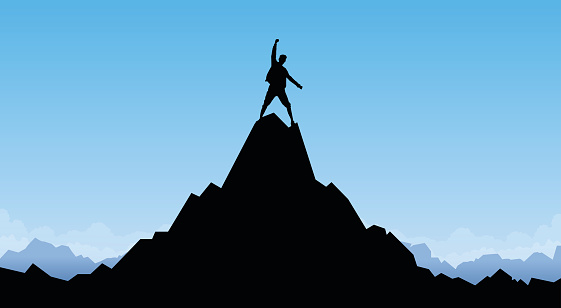

* Kendi başınıza en iyi olan yolu bulmak zor olurdu. Çünkü her birinden aşağı inmeniz ve bu istediğiniz çıkış değilse geri çıkmanız gerekirdi. Fakat indiğiniz yerlerin kenarlarında bir arkadaşınız olsa ve indiğiniz yer doğru değilse sizi geri çekse çok daha hızlı ilerleme kaydederdiniz. Böylece bir yarıkta sıkışıp kalma olasılığınız da azalmış olurdu.

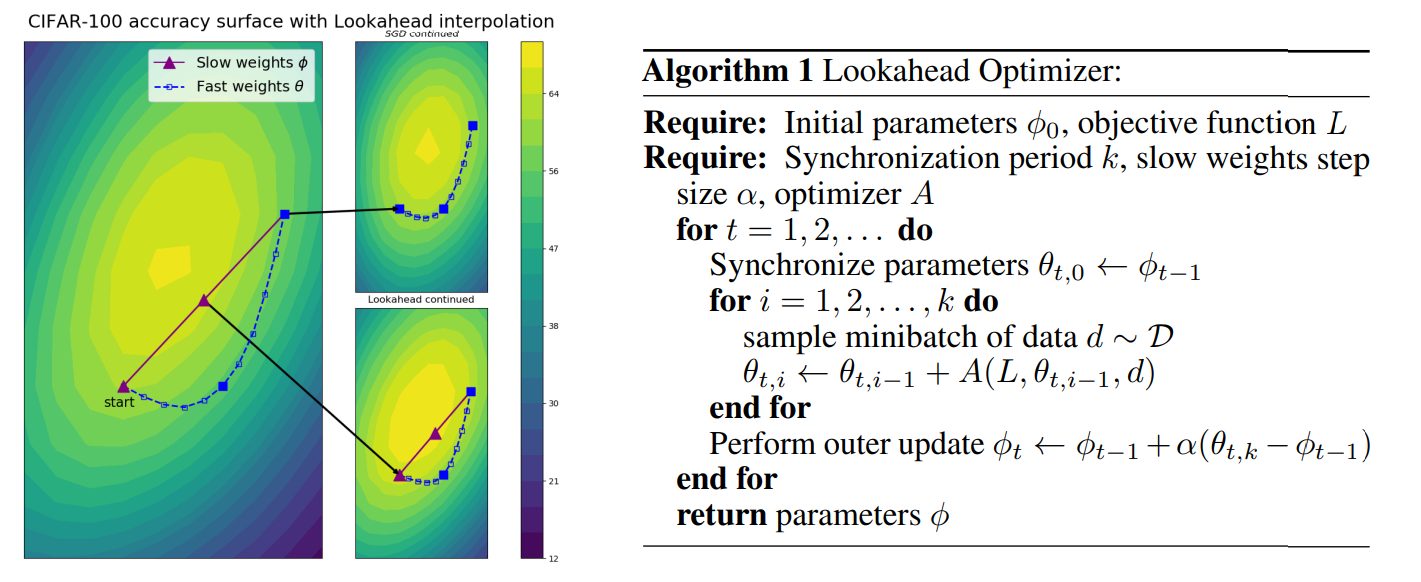

* Temel olarak Lookahead'in yaptığı budur. Ağırlıkların fazladan tek bir kopyasını tutar, ardından kendisine verilmiş "daha hızlı" optimizer'ın (RAdam) 5 veya 6 sonraki batch'i keşfetmesini sağlar. Keşif için kullanacağı batch aralığı, **k** parametresi ile belirtilir. 

* Lookahead daha sonra **k** aralığına ulaşıldığında kaydedilen ağırlıklar ile RAdam'ın en son ağırlıkları arasındaki farkı alır ve bunu her **k** grubunda bir alfa parametresiyle (varsayılan olarak .5) çarpar ve RAdam için ağırlıkları günceller.

#### Lazy-Adam
* Adam optimizer'ın bir varyantıdır. **Sparse** gradyanları (çoğunlukla sıfıra yakın) daha efektif şekilde güncelleyebilir. Daha çok NLP modellerinde yardımcı olabilir.

* Burada bu model için en iyi seçim olmayabilir :) Göstermek için kullanıyorum.

<br>

#### Çoklu Optimizer
* TensorFlow Addons sayesinde modelimizin belli layerların weightlerini istediğimiz bir optimizer ile optimize edebiliriz.

In [8]:
'''
Önceden 'imagenet' üzerinde train edilmiş olan DenseNet121 modelini kullanacağız.
'''
def base_model(inputs):

    base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    return base_model


'''
Neden Flatten() değil de GlobalPooling()?
* Model summary'de göründüğü gibi
densenet121 (Functional)  --> Output Shape   (None, 7, 7, 1024)

* Biz burada Flatten() yapsaydık 7 x 7 x 1024 tane parametre gelecekti.
* GlobalPooling() ile 1024 tane gelmiş oldu.
'''

def classifier(inputs):
    x = tf.keras.layers.GlobalMaxPooling2D()(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(0.14),
                              kernel_regularizer = tf.keras.regularizers.l2(0.00003))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
32 x 7 = 224, UpSampling.
* Normalde CNN'ler input shape ile ilgilenmez, neticede resim üzerinde kayan filtrelerdir.
* Fakat DenseNet121 224x224 resimler üzerinde eğitildiği için ve biz de en iyi performansı istediğimiz için
upsampling yapıyoruz.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)
    aug = data_augmentation(resize)
    densenet_base_model = base_model(aug)
    classification_output = classifier(densenet_base_model)

    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)

    optimizer_radam = tfa.optimizers.RectifiedAdam(learning_rate = 0.0001) # RAdam
    ranger = tfa.optimizers.Lookahead(optimizer_radam) # Ranger = Lookahead + RAdam
    
    optimizers = [
        tfa.optimizers.LazyAdam(learning_rate=1e-4),
        ranger
      ]
    # İlk 10 layer için LazyAdam, gerisi için Ranger.
    optimizers_and_layers = [(optimizers[0], model.layers[:10]), (optimizers[1], model.layers[10:])]
    optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)
    
    # Aynı şekilde optimizer olarak veriyoruz.
    model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])
    return model


model = define_compile_model()
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_max_pooling2d (Global (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
______________________________________________________________

## Eğitim Aşaması
* Sıradışı bir şey yok, `early_stopping` ekleyip eğitime başlıyoruz.

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                                      restore_best_weights=True)

callbacks = [es]

EPOCHS = 64
history = model.fit(train_ds, epochs=EPOCHS, validation_data = val_ds, callbacks = callbacks)

Epoch 1/64


2021-12-25 20:47:43.197053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


704/704 [==============================] - 266s 350ms/step - loss: 0.7949 - accuracy: 0.7305 - val_loss: 0.3126 - val_accuracy: 0.9006
Epoch 2/64
704/704 [==============================] - 245s 346ms/step - loss: 0.3385 - accuracy: 0.8899 - val_loss: 0.2454 - val_accuracy: 0.9204
Epoch 3/64
704/704 [==============================] - 245s 346ms/step - loss: 0.2491 - accuracy: 0.9187 - val_loss: 0.1884 - val_accuracy: 0.9392
Epoch 4/64
704/704 [==============================] - 245s 345ms/step - loss: 0.1967 - accuracy: 0.9359 - val_loss: 0.1675 - val_accuracy: 0.9470
Epoch 5/64
704/704 [==============================] - 244s 346ms/step - loss: 0.1648 - accuracy: 0.9459 - val_loss: 0.1775 - val_accuracy: 0.9450
Epoch 6/64
704/704 [==============================] - 245s 345ms/step - loss: 0.1432 - accuracy: 0.9549 - val_loss: 0.1729 - val_accuracy: 0.9444
Epoch 7/64
704/704 [==============================] - 244s 345ms/step - loss: 0.1312 - accuracy: 0.9581 - val_loss: 0.1942 - val_accura

## Modelin Değerlendirilmesi

In [10]:
loss, accuracy = model.evaluate(test_ds)

157/157 [==============================] - 16s 94ms/step - loss: 0.1868 - accuracy: 0.9503


### Loss ve Accuracy Eğrilerinin Plot Edilmesi

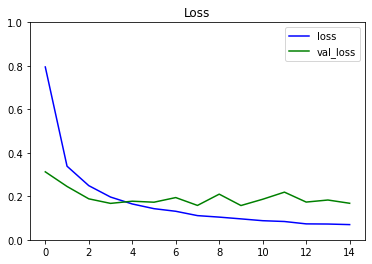

In [11]:
def plot_metrics(metric_name, title, ylim=1):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()

plot_metrics("loss", "Loss")

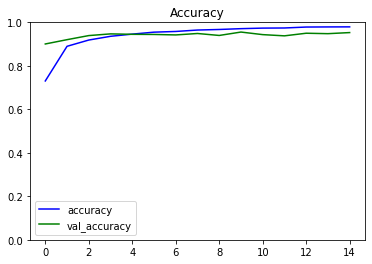

In [12]:
plot_metrics("accuracy", "Accuracy")